In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

k_fold = 10
seed = 42
np.random.seed(seed)

In [2]:
repeated_stratify_cv = RepeatedStratifiedKFold(n_splits=k_fold, n_repeats=3, random_state=seed)

#### 1 Read and describe data

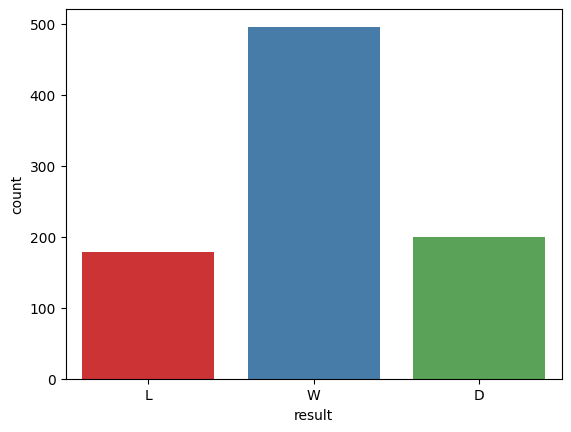

In [3]:
matches_df = pd.read_csv('data_rf.csv')
sns.countplot(x='result', data=matches_df, palette="Set1") 
matches_df.loc[matches_df["result"] == "W", "result"] = 0
matches_df.loc[matches_df["result"] == "L", "result"] = 1
matches_df.loc[matches_df["result"] == "D", "result"] = 2

### Chia dữ liệu

In [4]:
X = matches_df.drop("result", axis=1)
y = matches_df["result"].astype("int")

In [5]:
X

,venue,win_before_team1,win_before_team2,draw_before_team2,lose_before_team1,lose_before_team2,history_team1_win_team2,history_team1_draw_team2,history_team1_lose_team2,is_opponent_big6
0,Away,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,Home,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1
2,Home,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0
3,Away,0.666667,0.333333,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,1
4,Away,0.500000,0.250000,0.250000,0.250000,0.500000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...
870,Home,0.200000,0.000000,0.200000,0.200000,0.800000,0.311111,0.311111,0.377778,1
871,Away,0.200000,0.800000,0.000000,0.200000,0.200000,0.658537,0.219512,0.121951,0
872,Home,0.400000,0.600000,0.000000,0.200000,0.400000,0.363636,0.272727,0.363636,0
873,Away,0.400000,0.400000,0.200000,0.400000,0.400000,1.000000,0.000000,0.000000,0


In [6]:
# Xác định các cột phân loại và cột số
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Tạo ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ])

### Thử nghiệm các mô hình

In [7]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed, class_weight='balanced')),
    (
        "SVC",
        SVC(
            probability=True,
            random_state=seed,
            class_weight='balanced',
        ),
    ),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed, class_weight='balanced')),
    ("SGDC", CalibratedClassifierCV(SGDClassifier(random_state=seed, class_weight='balanced'))),
    ("NB", GaussianNB()),
    (
        "RF",
        RandomForestClassifier(
            n_estimators=100,
            random_state=seed,
            class_weight='balanced'
        ),
    ),
]

cv_results = {}
for name, model in algorithms:
    # Tạo pipeline bao gồm preprocessor và mô hình
    pipeline = Pipeline([("preprocessor", preprocessor), ("model", model)])
    
    # Thực hiện cross-validation
    cv_scores = cross_val_score(
        pipeline, X, y, cv=repeated_stratify_cv, scoring="accuracy"
    )
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    print(f"{name}: {score}")

LR: 0.4708507488679902
SVC: 0.46405433646812955
KNN: 0.5451410658307211
DTC: 0.46898293277603625
SGDC: 0.5691309648206201
NB: 0.5690917798676419
RF: 0.5664750957854406


### Thử nghiệm lại preprocessor

In [8]:
transformed_X = preprocessor.fit_transform(X)
new_columns = numerical_cols.to_list() + list(
    preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_cols)
)

transformed_X = pd.DataFrame(transformed_X, columns=new_columns)
transformed_X

,win_before_team1,win_before_team2,draw_before_team2,lose_before_team1,lose_before_team2,history_team1_win_team2,history_team1_draw_team2,history_team1_lose_team2,is_opponent_big6,venue_Away,venue_Home
0,-2.163616,-1.362390,-1.200677,-0.980361,-1.435440,-2.254012,-1.279594,-1.045951,-0.595390,1.0,0.0
1,-2.163616,2.376723,-1.200677,3.828923,-1.435440,-2.254012,-1.279594,-1.045951,1.679572,0.0,1.0
2,-0.186972,0.507166,-1.200677,1.424281,0.540040,-2.254012,-1.279594,-1.045951,-0.595390,0.0,1.0
3,0.471910,-0.116019,0.426005,0.622734,-0.118454,-2.254012,-1.279594,-1.045951,1.679572,1.0,0.0
4,-0.186972,-0.427612,0.019334,0.221960,0.540040,-2.254012,-1.279594,-1.045951,-0.595390,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
870,-1.372958,-1.362390,-0.224668,-0.018504,1.725328,-0.983496,0.436062,1.338160,1.679572,0.0,1.0
871,-1.372958,1.628900,-1.200677,-0.018504,-0.645248,0.435321,-0.069070,-0.276331,-0.595390,1.0,0.0
872,-0.582301,0.881078,-1.200677,-0.018504,0.144944,-0.768993,0.224390,1.248916,-0.595390,0.0,1.0
873,-0.582301,0.133255,-0.224668,0.943353,0.144944,1.829791,-1.279594,-1.045951,-0.595390,1.0,0.0


In [9]:
X = transformed_X

# Chọn bộ siêu tham số

### SVC

In [16]:
best_params_SVC = {}
models_tuned_SVC = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("SVC", SVC(probability=True)),
]

# Define parameter grid with correct keys
param_grid = {
    "SVC": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Expanded C range
        "gamma": [0.001, 0.01, 0.1, 1, 10, 100],  # More granular gamma range
        "kernel": ["linear", "poly", "rbf", "sigmoid"],  # Added kernel options
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_SVC[name] = randomized_search.best_params_
        models_tuned_SVC[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


Model processing:  SVC
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [17]:
with open('best_params/best_params_SVC.json', 'w') as f:
    json.dump(best_params_SVC, f)

### RF

In [ ]:
best_params_RF = {}
models_tuned_RF = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ('RF', RandomForestClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "RF": {
        "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],  # More options for n_estimators
        "max_features": ["sqrt", "log2", 0.2, 0.4, 0.6],  # More granular control
        "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],  # Added max_depth
        "min_samples_split": [2, 5, 10, 20],  # Added min_samples_split
        "min_samples_leaf": [1, 2, 4, 6],  # Added min_samples_leaf
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_RF[name] = randomized_search.best_params_
        models_tuned_RF[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


### Các thuật toán khác

In [52]:
best_params_random_other = {}
models_tuned_random_other = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("LR", LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "LR": {
        "C": np.logspace(-4, 4, 20),  # More granular range for C
        "solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # Added 'newton-cg'
        "penalty": ["l1", "l2", "elasticnet", "none"],  # Different norms for regularization
    },
    "DTC": {
        "max_depth": [None, 3, 5, 10, 15, 20, 30, 50, 100],  # Expanded range
        "min_samples_split": [2, 5, 10, 20, 40, 100],  # More options
        "min_samples_leaf": [1, 2, 5, 10, 20],  # Added min_samples_leaf
    },
    "KNN": {
        "n_neighbors": list(range(1, 21)),  # More neighbors
        "weights": ["uniform", "distance"],  # Existing weights
        "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]  # Added distance metrics
    },
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_random_other[name] = randomized_search.best_params_
        models_tuned_random_other[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


Model processing:  LR
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model processing:  KNN
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model processing:  DTC
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [53]:
with open('best_params/best_params_random_other_balanced.json', 'w') as f:
    json.dump(best_params_random_other, f)

#### Thử nghiệm bộ tham số

In [41]:
algorithms_score_df = []
algorithms_score_df_resampling = []

In [11]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### SVC

##### Trước resampling

In [42]:
with open('best_params/best_params_SVC.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("SVC", SVC(probability=True, **best_params.get("SVC", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name,
        "score": score
    })
    print(f"{name}: {score}")

SVC: 0.574857142857143


##### Sau resampling by balancing

In [43]:
with open('best_params/best_params_SVC_balanced.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("SVC", SVC(probability=True, **best_params.get("SVC", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df_resampling.append({
        "model": name,
        "score": score
    })
    print(f"{name}: {score}")

SVC: 0.5302857142857142


##### Random forest

##### Trước resampling

In [44]:
with open('best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ('RF', RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name,
        "score": score
    })
    print(f"{name}: {score}")

RF: 0.6022857142857143


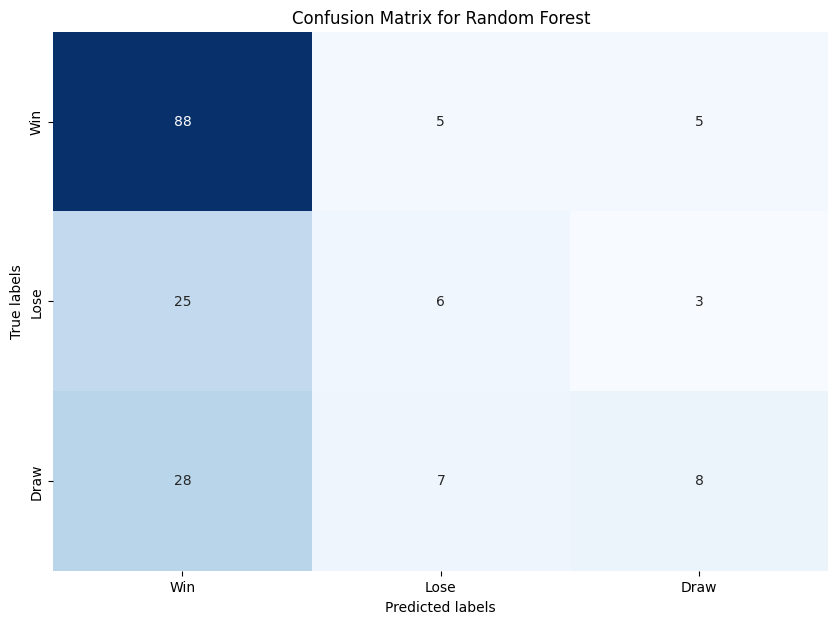

In [45]:
with open('best_params/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)

rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=42)

y_pred = rf_model.fit(X_train, y_train).predict(X_test)
# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa nhãn cho các trục tương ứng với các lớp của 'Result'
labels = ['Win', 'Lose', 'Draw']

df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

##### Sau resampling by balancing

In [46]:
with open('best_params/best_params_RF_balanced.json', 'r') as f:
    best_params_RF = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ('RF', RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df_resampling.append({
        "model": name,
        "score": score
    })
    print(f"{name}: {score}")

RF: 0.5577142857142857


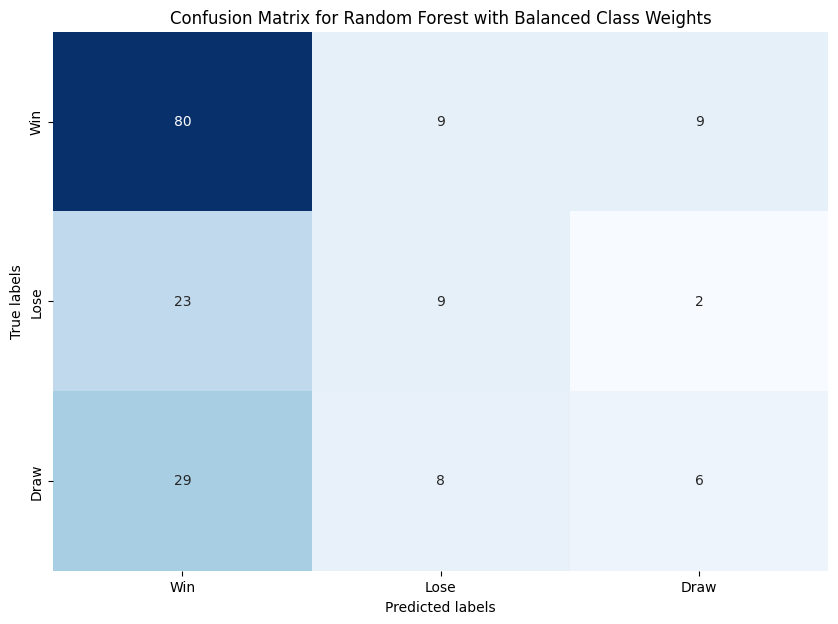

In [47]:
with open('best_params/best_params_RF_balanced.json', 'r') as f:
    best_params_RF = json.load(f)

rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=42)

y_pred = rf_model.fit(X_train, y_train).predict(X_test)
# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa nhãn cho các trục tương ứng với các lớp của 'Result'
labels = ['Win', 'Lose', 'Draw']

df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest with Balanced Class Weights')
plt.show()

##### Sau resampling by punishing model

In [49]:
best_params_RF = {
    "n_estimators": 2000,  # Example hyperparameter values
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "max_features": 0.2, 
    "max_depth": 70,
    "class_weight": {
        "0": 0.1,
        "1": 0.45,
        "2": 0.45
    }
}

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ('RF', RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    print(f"{name}: {score}")

RF: 0.544


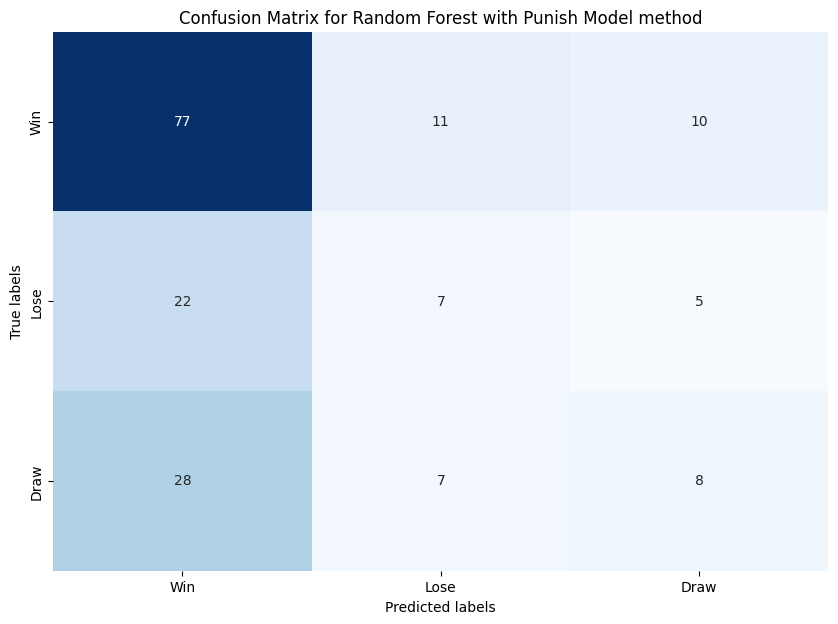

In [50]:
best_params_RF = {
    "n_estimators": 1200,  # Example hyperparameter values
    "min_samples_split": 20,
    "min_samples_leaf": 4,
    "max_features": 0.6, 
    "max_depth": 100,
    "class_weight": {
        "0": 0.1,
        "1": 0.45,
        "2": 0.45
    }
}

rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), class_weight='balanced', random_state=42)

y_pred = rf_model.fit(X_train, y_train).predict(X_test)
# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa nhãn cho các trục tương ứng với các lớp của 'Result'
labels = ['Win', 'Lose', 'Draw']

df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest with Punish Model method')
plt.show()

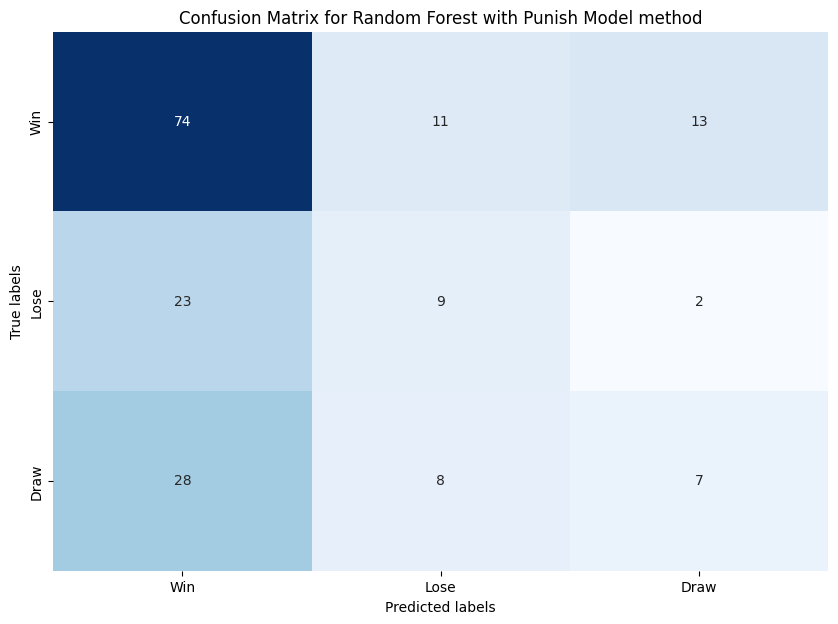

In [51]:
best_params_RF = {
    "n_estimators": 1200,  # Example hyperparameter values
    "min_samples_split": 20,
    "min_samples_leaf": 4,
    "max_features": 0.6, 
    "max_depth": 100,
    "class_weight": {
        "0": 0.1, # W
        "1": 0.45, # L
        "2": 0.45 # D
    }
}

rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=42)

y_pred = rf_model.fit(X_train, y_train).predict(X_test)
# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa nhãn cho các trục tương ứng với các lớp của 'Result'
labels = ['Win', 'Lose', 'Draw']

df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest with Punish Model method')
plt.show()

#### Các thuật toán khác: LR, KNN, DTC

##### Trước resampling

In [52]:
with open('best_params/best_params_random_other.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=42)),
    ('KNN', KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name,
        "score": score
    })
    print(f"{name}: {score}")

LR: 0.6034285714285714
KNN: 0.5885714285714286
DTC: 0.598857142857143


##### Sau resampling by balancing

In [53]:
with open('best_params/best_params_random_other_balanced.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=42)),
    ('KNN', KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df_resampling.append({
        "model": name,
        "score": score
    })
    print(f"{name}: {score}")

LR: 0.5657142857142856
KNN: 0.5897142857142856
DTC: 0.4868571428571428


In [54]:
df = pd.DataFrame(algorithms_score_df)
df.sort_values(by="score", ascending=False)

,model,score
2,LR,0.603429
1,RF,0.602286
4,DTC,0.598857
3,KNN,0.588571
0,SVC,0.574857


In [55]:
df = pd.DataFrame(algorithms_score_df_resampling)
df.sort_values(by="score", ascending=False)

,model,score
3,KNN,0.589714
2,LR,0.565714
1,RF,0.557714
0,SVC,0.530286
4,DTC,0.486857


#### Vẽ ma trận nhầm lẫn của model có độ chính xác cao nhất 

##### Logistic regression

##### Trước resampling

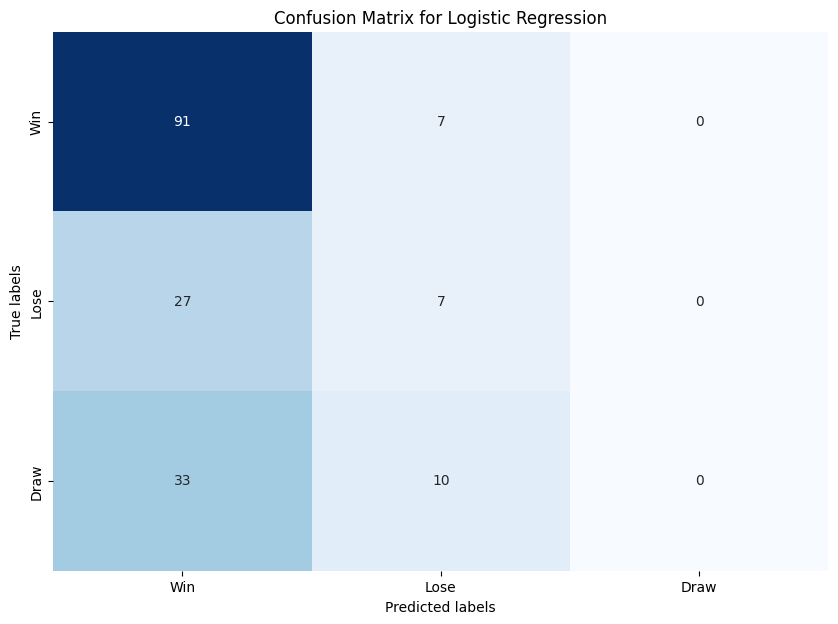

In [56]:
with open('best_params/best_params_random_other.json', 'r') as f:
    best_params_other = json.load(f)

lr_model = LogisticRegression(**best_params_other.get("LR", {}), random_state=42)

y_pred = lr_model.fit(X_train, y_train).predict(X_test)
# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa nhãn cho các trục tương ứng với các lớp của 'Result'
labels = ['Win', 'Lose', 'Draw']

df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

##### Sau resampling by balancing

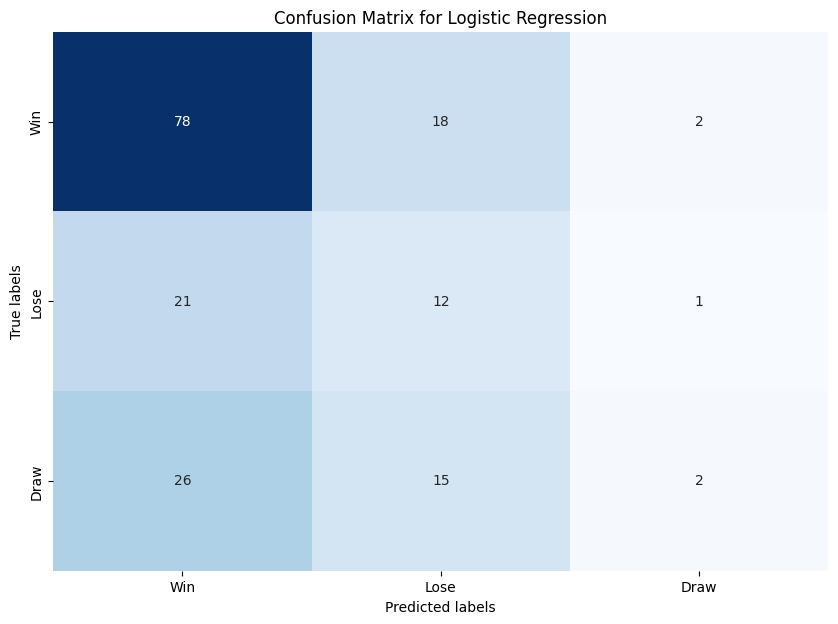

In [57]:
with open('best_params/best_params_random_other_balanced.json', 'r') as f:
    best_params_other = json.load(f)

lr_model = LogisticRegression(**best_params_other.get("LR", {}), random_state=42)

y_pred = lr_model.fit(X_train, y_train).predict(X_test)
# Tạo ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Định nghĩa nhãn cho các trục tương ứng với các lớp của 'Result'
labels = ['Win', 'Lose', 'Draw']

df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Vẽ ma trận confusion với nhãn cụ thể
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()